## 作業

1. 請改變 reduce learning rate 不同的 patience 和 factor，並比較對訓練集/驗證集的影響。
2. 請改變 optimizer 換成 Adam 和 RMSprop ，並搭配 reduce learning rate 不同的 patience 和 factor，並比較對訓練集/驗證集的影響。

## 參考資料

[Keras callbacks.py 原始碼 - GitHub](https://github.com/keras-team/keras/blob/master/keras/callbacks.py)

In [1]:
import itertools
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from keras import backend
from keras.utils import np_utils
from keras.datasets import cifar10
from keras.models import Model
from keras.layers import Input, Dense, BatchNormalization
from keras.optimizers import SGD, Adam, RMSprop
from keras.callbacks import ReduceLROnPlateau
tf.logging.set_verbosity(tf.logging.ERROR)

Using TensorFlow backend.


## 準備資料

In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [3]:
def normalize_cifar10_data(x, y):
    x = x.reshape((len(x), -1)) / 255.
    y = np_utils.to_categorical(y, num_classes=10)
    return x, y

def normalize_result(x, y):
    print('x.shape:', x.shape)
    print('y.shape:', y.shape)

In [4]:
print('Before normalization:')
normalize_result(X_train, y_train)

Before normalization:
x.shape: (50000, 32, 32, 3)
y.shape: (50000, 1)


In [5]:
print('After normalization:')
X_train, y_train = normalize_cifar10_data(X_train, y_train)
X_test, y_test = normalize_cifar10_data(X_test, y_test)
normalize_result(X_train, y_train)

After normalization:
x.shape: (50000, 3072)
y.shape: (50000, 10)


## 定義函數

In [6]:
class Trainer:

    def __init__(self, X_train, y_train, X_test, y_test, build_param, neuron_numbers=(512, 256, 128,),
                 epochs=50, batch_size=1024, learning_rate=1e-3):
        self.X_test = X_test
        self.y_test = y_test
        self.X_train = X_train
        self.y_train = y_train
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.neuron_numbers = neuron_numbers
        self.build_param = build_param
        self._model = None
        self._history = None

    @property
    def optimizer(self):
        clz, param = self.build_param.optimizer_clz, self.build_param.optimizer_param
        return clz(lr=self.learning_rate, **param)

    @property
    def callbacks(self):
        factor, patience = self.build_param.rlrop_factor, self.build_param.rlrop_patience
        return [ReduceLROnPlateau(factor=factor, patience=patience, min_lr=1e-12, verbose=1)]

    @property
    def validation_data(self):
        return (self.X_test, self.y_test,)

    def run(self):
        return self._clear()._build()._launch()

    def _clear(self):
        backend.clear_session()
        self._model = None
        return self

    def _build(self):
        main_input = hidden_input = Input(shape=self.X_train.shape[-1:], name='main_input')
        for i, neuron_number in enumerate(self.neuron_numbers):
            hidden_input = Dense(units=neuron_number, activation='relu', name=f'hidden_layer{i}')(hidden_input)
            hidden_input = BatchNormalization()(hidden_input)
        main_output = Dense(units=self.y_train.shape[-1], activation='softmax', name='main_output')(hidden_input)
        self._model = Model(inputs=[main_input], outputs=[main_output])
        self._model.compile(optimizer=self.optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
        return self

    def _launch(self):
        print('Experiment with label: {}'.format(self.build_param.label))
        self._model.summary()
        self._history = self._model.fit(
            self.X_train, self.y_train, epochs=self.epochs, batch_size=self.batch_size,
            validation_data=self.validation_data, callbacks=self.callbacks, shuffle=True, verbose=2)
        return self

    def display(self, train_name, val_name, color):
        plt.plot(self._history.history[train_name], '-', label='exp: {}'.format(self.build_param.label), color=color)
        plt.plot(self._history.history[val_name], '--', label='exp: {}'.format(self.build_param.label), color=color)

class BuildParam:

    def __init__(self, optimizer_clz, optimizer_param, rlrop_factor, rlrop_patience):
        self.optimizer_clz = optimizer_clz
        self.optimizer_param = optimizer_param
        self.rlrop_factor = rlrop_factor
        self.rlrop_patience = rlrop_patience

    @property
    def label(self):
        return 'op={}, ft={:.2f}, pt={}'.format(self.optimizer_clz.__name__.lower(), self.rlrop_factor, self.rlrop_patience)

class BatchTrainer:
    
    def __init__(self, trainers):
        self.trainers = trainers
        self.total_amount = len(trainers)

    @property
    def colors(self):
        color_map = cm.ScalarMappable(cmap=plt.get_cmap('gist_rainbow'),
                                      norm=colors.Normalize(vmin=0, vmax=self.total_amount - 1))
        return [color_map.to_rgba(i) for i in range(self.total_amount)]

    def run(self):
        for i in range(self.total_amount):
            self.trainers[i].run()
        return self

    def display(self, train_name, val_name):
        plt.figure(figsize=(12, 7,))
        for i, color in enumerate(self.colors):
            self.trainers[i].display(train_name, val_name, color)
        plt.xlabel('Epoch')
        plt.ylabel(train_name)
        plt.title('Train History')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5,))
        plt.show()

## 以 SGD 優化器和不同的降低學習率參數觀看學習曲線的走勢

In [7]:
# 設定超參數
optimizers = [(SGD, {'momentum': 0.95, 'nesterov': True},)]
rlrop_factors = [0.1, 0.3, 0.5]
rlrop_patiences = [5, 10, 15]

params = [BuildParam(*optimizer, rlrop_factor, rlrop_patience) for optimizer, rlrop_factor, rlrop_patience
          in itertools.product(optimizers, rlrop_factors, rlrop_patiences)]
trainers = [Trainer(X_train, y_train, X_test, y_test, param) for param in params]

In [8]:
batch_trainer = BatchTrainer(trainers).run()

Experiment with label: op=sgd, ft=0.10, pt=5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 3072)              0         
_________________________________________________________________
hidden_layer0 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (N

Epoch 9/50
 - 8s - loss: 1.3399 - acc: 0.5335 - val_loss: 1.5081 - val_acc: 0.4693
Epoch 10/50
 - 8s - loss: 1.3099 - acc: 0.5440 - val_loss: 1.4936 - val_acc: 0.4708
Epoch 11/50
 - 8s - loss: 1.2822 - acc: 0.5548 - val_loss: 1.4963 - val_acc: 0.4790
Epoch 12/50
 - 8s - loss: 1.2575 - acc: 0.5618 - val_loss: 1.4845 - val_acc: 0.4808
Epoch 13/50
 - 8s - loss: 1.2291 - acc: 0.5747 - val_loss: 1.4739 - val_acc: 0.4801
Epoch 14/50
 - 8s - loss: 1.2041 - acc: 0.5834 - val_loss: 1.4600 - val_acc: 0.4883
Epoch 15/50
 - 8s - loss: 1.1809 - acc: 0.5920 - val_loss: 1.4577 - val_acc: 0.4884
Epoch 16/50
 - 8s - loss: 1.1566 - acc: 0.6007 - val_loss: 1.4606 - val_acc: 0.4843
Epoch 17/50
 - 8s - loss: 1.1336 - acc: 0.6102 - val_loss: 1.4615 - val_acc: 0.4898
Epoch 18/50
 - 8s - loss: 1.1128 - acc: 0.6159 - val_loss: 1.4543 - val_acc: 0.4894
Epoch 19/50
 - 8s - loss: 1.0892 - acc: 0.6253 - val_loss: 1.4472 - val_acc: 0.4907
Epoch 20/50
 - 8s - loss: 1.0680 - acc: 0.6347 - val_loss: 1.4463 - val_acc: 

Epoch 37/50
 - 9s - loss: 0.7148 - acc: 0.7754 - val_loss: 1.5109 - val_acc: 0.5061
Epoch 38/50
 - 9s - loss: 0.6951 - acc: 0.7825 - val_loss: 1.5433 - val_acc: 0.5000
Epoch 39/50
 - 9s - loss: 0.6769 - acc: 0.7896 - val_loss: 1.5370 - val_acc: 0.5061

Epoch 00039: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 40/50
 - 9s - loss: 0.6752 - acc: 0.7895 - val_loss: 1.5384 - val_acc: 0.5069
Epoch 41/50
 - 9s - loss: 0.6352 - acc: 0.8090 - val_loss: 1.5229 - val_acc: 0.5119
Epoch 42/50
 - 9s - loss: 0.6208 - acc: 0.8183 - val_loss: 1.5233 - val_acc: 0.5088
Epoch 43/50
 - 9s - loss: 0.6165 - acc: 0.8203 - val_loss: 1.5265 - val_acc: 0.5113
Epoch 44/50
 - 9s - loss: 0.6125 - acc: 0.8223 - val_loss: 1.5261 - val_acc: 0.5087
Epoch 45/50
 - 9s - loss: 0.6108 - acc: 0.8223 - val_loss: 1.5287 - val_acc: 0.5108
Epoch 46/50
 - 9s - loss: 0.6082 - acc: 0.8241 - val_loss: 1.5317 - val_acc: 0.5110
Epoch 47/50
 - 9s - loss: 0.6066 - acc: 0.8245 - val_loss: 1.5332 - val_acc: 0

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
 - 9s - loss: 2.2117 - acc: 0.2691 - val_loss: 2.1610 - val_acc: 0.3246
Epoch 2/50
 - 8s - loss: 1.7512 - acc: 0.3897 - val_loss: 1.8417 - val_acc: 0.3720
Epoch 3/50
 - 8s - loss: 1.6248 - acc: 0.4318 - val_loss: 1.6712 - val_acc: 0.4212
Epoch 4/50
 - 8s - loss: 1.5484 - acc: 0.4584 - val_loss: 1.6371 - val_acc: 0.4291
Epoch 5/50
 - 8s - loss: 1.4937 - acc: 0.4782 - val_loss: 1.6069 - val_acc: 0.4337
Epoch 6/50
 - 8s - loss: 1.4485 - acc: 0.4927 - val_loss: 1.5638 - val_acc: 0.4504
Epoch 7/50
 - 8s - loss: 1.4069 - acc: 0.5078 - val_loss: 1.5414 - val_acc: 0.4562
Epoch 8/50
 - 8s - loss: 1.3684 - acc: 0.5225 - val_loss: 1.5124 - val_acc: 0.4658
Epoch 9/50
 - 8s - loss: 1.3354 - acc: 0.5347 - val_loss: 1.5128 - val_acc: 0.4678
Epoch 10/50
 - 8s - loss: 1.3047 - acc: 0.5456 - val_loss: 1.5050 - val_acc: 0.4683
Epoch 11/50
 - 8s - loss: 1.2772 - acc: 0.5557 - val_loss: 1.4945 - val_acc: 0.4711
Epoch 12/50
 - 8s - loss: 1.2499 - 

Epoch 29/50
 - 8s - loss: 0.8825 - acc: 0.7090 - val_loss: 1.4540 - val_acc: 0.5065
Epoch 30/50
 - 8s - loss: 0.8633 - acc: 0.7163 - val_loss: 1.4787 - val_acc: 0.5018
Epoch 31/50
 - 8s - loss: 0.8422 - acc: 0.7235 - val_loss: 1.4689 - val_acc: 0.5047
Epoch 32/50
 - 8s - loss: 0.8225 - acc: 0.7328 - val_loss: 1.4739 - val_acc: 0.5069
Epoch 33/50
 - 8s - loss: 0.8039 - acc: 0.7407 - val_loss: 1.4911 - val_acc: 0.5006
Epoch 34/50
 - 8s - loss: 0.7859 - acc: 0.7469 - val_loss: 1.4816 - val_acc: 0.5087
Epoch 35/50
 - 8s - loss: 0.7649 - acc: 0.7555 - val_loss: 1.4986 - val_acc: 0.5023
Epoch 36/50
 - 9s - loss: 0.7475 - acc: 0.7630 - val_loss: 1.5053 - val_acc: 0.5023

Epoch 00036: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 37/50
 - 8s - loss: 0.7204 - acc: 0.7742 - val_loss: 1.5008 - val_acc: 0.5083
Epoch 38/50
 - 8s - loss: 0.6964 - acc: 0.7845 - val_loss: 1.4926 - val_acc: 0.5101
Epoch 39/50
 - 9s - loss: 0.6868 - acc: 0.7904 - val_loss: 1.5043 - val_acc: 0.

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
 - 9s - loss: 2.2233 - acc: 0.2676 - val_loss: 2.0963 - val_acc: 0.3297
Epoch 2/50
 - 8s - loss: 1.7577 - acc: 0.3858 - val_loss: 1.8281 - val_acc: 0.3820
Epoch 3/50
 - 8s - loss: 1.6293 - acc: 0.4315 - val_loss: 1.7029 - val_acc: 0.4052
Epoch 4/50
 - 8s - loss: 1.5521 - acc: 0.4579 - val_loss: 1.6477 - val_acc: 0.4228
Epoch 5/50
 - 8s - loss: 1.4930 - acc: 0.4790 - val_loss: 1.6180 - val_acc: 0.4306
Epoch 6/50
 - 8s - loss: 1.4455 - acc: 0.4967 - val_loss: 1.5876 - val_acc: 0.4443
Epoch 7/50
 - 8s - loss: 1.4056 - acc: 0.5119 - val_loss: 1.5463 - val_acc: 0.4565
Epoch 8/50
 - 8s - loss: 1.3681 - acc: 0.5233 - val_loss: 1.5290 - val_acc: 0.4632
Epoch 9/50
 - 8s - loss: 1.3358 - acc: 0.5360 - val_loss: 1.5234 - val_acc: 0.4636
Epoch 10/50
 - 9s - loss: 1.3048 - acc: 0.5467 - val_loss: 1.5157 - val_acc: 0.4677
Epoch 11/50
 - 8s - loss: 1.2757 - acc: 0.5581 - val_loss: 1.4997 - val_acc: 0.4714
Epoch 12/50
 - 8s - loss: 1.2484 - 

Epoch 28/50
 - 9s - loss: 0.9108 - acc: 0.6955 - val_loss: 1.4758 - val_acc: 0.4871
Epoch 29/50
 - 9s - loss: 0.8901 - acc: 0.7048 - val_loss: 1.4910 - val_acc: 0.4883
Epoch 30/50
 - 9s - loss: 0.8692 - acc: 0.7139 - val_loss: 1.4841 - val_acc: 0.4895
Epoch 31/50
 - 9s - loss: 0.8509 - acc: 0.7198 - val_loss: 1.5260 - val_acc: 0.4814
Epoch 32/50
 - 9s - loss: 0.8322 - acc: 0.7281 - val_loss: 1.4877 - val_acc: 0.4919
Epoch 33/50
 - 8s - loss: 0.8116 - acc: 0.7366 - val_loss: 1.5019 - val_acc: 0.4890
Epoch 34/50
 - 9s - loss: 0.7924 - acc: 0.7432 - val_loss: 1.5018 - val_acc: 0.4933
Epoch 35/50
 - 9s - loss: 0.7731 - acc: 0.7509 - val_loss: 1.5084 - val_acc: 0.4938

Epoch 00035: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 36/50
 - 9s - loss: 0.7461 - acc: 0.7646 - val_loss: 1.5041 - val_acc: 0.4924
Epoch 37/50
 - 9s - loss: 0.7268 - acc: 0.7718 - val_loss: 1.5153 - val_acc: 0.4965
Epoch 38/50
 - 9s - loss: 0.7161 - acc: 0.7760 - val_loss: 1.5202 - val_acc: 0.

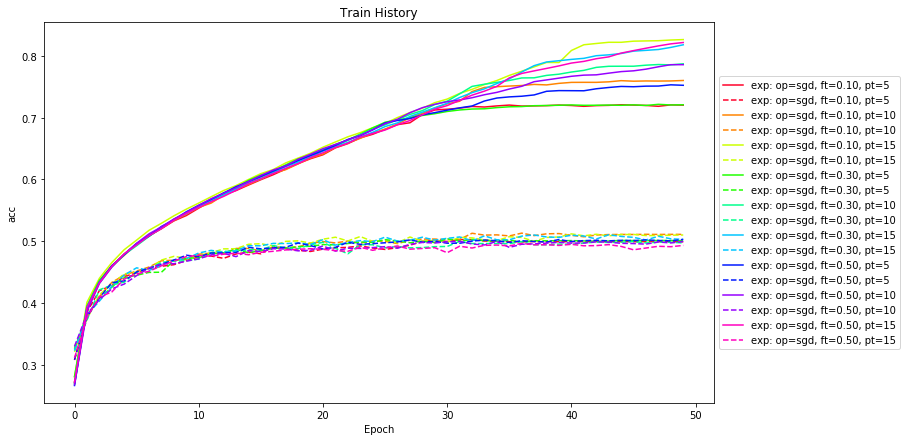

In [9]:
batch_trainer.display('acc', 'val_acc')

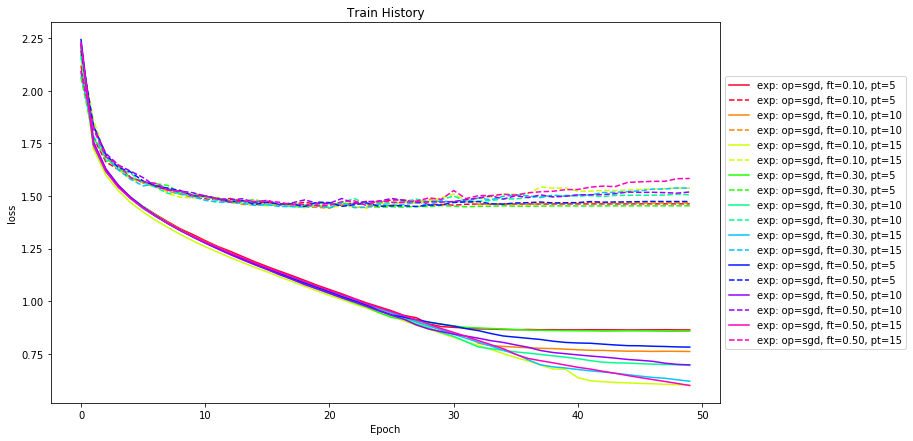

In [10]:
batch_trainer.display('loss', 'val_loss')

## 以 Adam 優化器和不同的降低學習率參數觀看學習曲線的走勢

In [11]:
# 設定超參數
optimizers = [(Adam, {},)]
rlrop_factors = [0.1, 0.3, 0.5]
rlrop_patiences = [5, 10, 15]

params = [BuildParam(*optimizer, rlrop_factor, rlrop_patience) for optimizer, rlrop_factor, rlrop_patience
          in itertools.product(optimizers, rlrop_factors, rlrop_patiences)]
trainers = [Trainer(X_train, y_train, X_test, y_test, param) for param in params]

In [12]:
batch_trainer = BatchTrainer(trainers).run()

Experiment with label: op=adam, ft=0.10, pt=5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 3072)              0         
_________________________________________________________________
hidden_layer0 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (

Epoch 7/50
 - 9s - loss: 1.1345 - acc: 0.6037 - val_loss: 1.8631 - val_acc: 0.3771
Epoch 8/50
 - 9s - loss: 1.0934 - acc: 0.6178 - val_loss: 2.1531 - val_acc: 0.3567
Epoch 9/50
 - 9s - loss: 1.0510 - acc: 0.6322 - val_loss: 1.9737 - val_acc: 0.3306
Epoch 10/50
 - 9s - loss: 1.0062 - acc: 0.6488 - val_loss: 1.8995 - val_acc: 0.3800
Epoch 11/50
 - 9s - loss: 0.9699 - acc: 0.6620 - val_loss: 2.0479 - val_acc: 0.3626
Epoch 12/50
 - 9s - loss: 0.9277 - acc: 0.6765 - val_loss: 1.9419 - val_acc: 0.3938

Epoch 00012: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 13/50
 - 9s - loss: 0.7993 - acc: 0.7302 - val_loss: 1.4410 - val_acc: 0.5101
Epoch 14/50
 - 9s - loss: 0.7426 - acc: 0.7562 - val_loss: 1.3646 - val_acc: 0.5353
Epoch 15/50
 - 9s - loss: 0.7199 - acc: 0.7648 - val_loss: 1.3451 - val_acc: 0.5378
Epoch 16/50
 - 9s - loss: 0.7036 - acc: 0.7716 - val_loss: 1.3553 - val_acc: 0.5337
Epoch 17/50
 - 9s - loss: 0.6877 - acc: 0.7777 - val_loss: 1.3472 - val_acc: 0.53

Epoch 32/50
 - 9s - loss: 0.2974 - acc: 0.9276 - val_loss: 1.6253 - val_acc: 0.5308
Epoch 33/50
 - 9s - loss: 0.2884 - acc: 0.9306 - val_loss: 1.6318 - val_acc: 0.5259
Epoch 34/50
 - 9s - loss: 0.2823 - acc: 0.9337 - val_loss: 1.6496 - val_acc: 0.5333
Epoch 35/50
 - 9s - loss: 0.2748 - acc: 0.9351 - val_loss: 1.6493 - val_acc: 0.5297
Epoch 36/50
 - 9s - loss: 0.2681 - acc: 0.9385 - val_loss: 1.6893 - val_acc: 0.5275
Epoch 37/50
 - 9s - loss: 0.2602 - acc: 0.9409 - val_loss: 1.6889 - val_acc: 0.5280
Epoch 38/50
 - 9s - loss: 0.2535 - acc: 0.9440 - val_loss: 1.7056 - val_acc: 0.5272
Epoch 39/50
 - 9s - loss: 0.2475 - acc: 0.9460 - val_loss: 1.7255 - val_acc: 0.5290

Epoch 00039: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 40/50
 - 9s - loss: 0.2310 - acc: 0.9540 - val_loss: 1.7101 - val_acc: 0.5296
Epoch 41/50
 - 9s - loss: 0.2282 - acc: 0.9549 - val_loss: 1.7094 - val_acc: 0.5323
Epoch 42/50
 - 9s - loss: 0.2266 - acc: 0.9553 - val_loss: 1.7119 - val_acc: 0

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
 - 10s - loss: 1.7724 - acc: 0.3835 - val_loss: 2.0644 - val_acc: 0.3462
Epoch 2/50
 - 9s - loss: 1.4977 - acc: 0.4717 - val_loss: 1.7106 - val_acc: 0.3862
Epoch 3/50
 - 9s - loss: 1.3952 - acc: 0.5088 - val_loss: 1.7733 - val_acc: 0.3696
Epoch 4/50
 - 9s - loss: 1.3151 - acc: 0.5363 - val_loss: 1.7514 - val_acc: 0.3896
Epoch 5/50
 - 9s - loss: 1.2519 - acc: 0.5601 - val_loss: 1.8702 - val_acc: 0.3745
Epoch 6/50
 - 9s - loss: 1.1905 - acc: 0.5817 - val_loss: 2.2767 - val_acc: 0.3125
Epoch 7/50
 - 9s - loss: 1.1435 - acc: 0.5969 - val_loss: 2.0711 - val_acc: 0.3148
Epoch 8/50
 - 9s - loss: 1.0936 - acc: 0.6138 - val_loss: 1.9208 - val_acc: 0.3635
Epoch 9/50
 - 9s - loss: 1.0539 - acc: 0.6296 - val_loss: 1.7305 - val_acc: 0.4088
Epoch 10/50
 - 9s - loss: 1.0071 - acc: 0.6453 - val_loss: 1.8294 - val_acc: 0.3933
Epoch 11/50
 - 9s - loss: 0.9648 - acc: 0.6623 - val_loss: 2.1937 - val_acc: 0.3735
Epoch 12/50
 - 9s - loss: 0.9158 -

Epoch 27/50
 - 9s - loss: 0.4436 - acc: 0.8485 - val_loss: 2.3517 - val_acc: 0.4231
Epoch 28/50
 - 9s - loss: 0.4218 - acc: 0.8562 - val_loss: 2.6810 - val_acc: 0.3903
Epoch 29/50
 - 9s - loss: 0.3834 - acc: 0.8721 - val_loss: 2.2219 - val_acc: 0.4537
Epoch 30/50
 - 9s - loss: 0.3497 - acc: 0.8845 - val_loss: 2.3490 - val_acc: 0.4394
Epoch 31/50
 - 9s - loss: 0.3317 - acc: 0.8901 - val_loss: 2.3274 - val_acc: 0.4585
Epoch 32/50
 - 9s - loss: 0.3188 - acc: 0.8934 - val_loss: 2.2581 - val_acc: 0.4463

Epoch 00032: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 33/50
 - 9s - loss: 0.2036 - acc: 0.9465 - val_loss: 1.9398 - val_acc: 0.5127
Epoch 34/50
 - 9s - loss: 0.1517 - acc: 0.9700 - val_loss: 1.9604 - val_acc: 0.5184
Epoch 35/50
 - 9s - loss: 0.1349 - acc: 0.9752 - val_loss: 1.9982 - val_acc: 0.5170
Epoch 36/50
 - 9s - loss: 0.1233 - acc: 0.9797 - val_loss: 2.0452 - val_acc: 0.5176
Epoch 37/50
 - 9s - loss: 0.1141 - acc: 0.9823 - val_loss: 2.0708 - val_acc: 0.

 - 9s - loss: 0.2908 - acc: 0.9374 - val_loss: 1.6475 - val_acc: 0.5225
Epoch 49/50
 - 9s - loss: 0.2898 - acc: 0.9381 - val_loss: 1.6465 - val_acc: 0.5234
Epoch 50/50
 - 9s - loss: 0.2893 - acc: 0.9384 - val_loss: 1.6491 - val_acc: 0.5227
Experiment with label: op=adam, ft=0.50, pt=10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 3072)              0         
_________________________________________________________________
hidden_layer0 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)             

Epoch 8/50
 - 9s - loss: 1.0964 - acc: 0.6146 - val_loss: 2.0010 - val_acc: 0.3557
Epoch 9/50
 - 9s - loss: 1.0559 - acc: 0.6286 - val_loss: 1.9532 - val_acc: 0.3548
Epoch 10/50
 - 9s - loss: 1.0005 - acc: 0.6482 - val_loss: 1.9725 - val_acc: 0.3773
Epoch 11/50
 - 9s - loss: 0.9648 - acc: 0.6617 - val_loss: 1.8991 - val_acc: 0.3965
Epoch 12/50
 - 9s - loss: 0.9347 - acc: 0.6722 - val_loss: 1.8494 - val_acc: 0.3964
Epoch 13/50
 - 9s - loss: 0.8895 - acc: 0.6913 - val_loss: 1.8656 - val_acc: 0.4133
Epoch 14/50
 - 9s - loss: 0.8474 - acc: 0.7035 - val_loss: 2.1426 - val_acc: 0.3743
Epoch 15/50
 - 9s - loss: 0.8051 - acc: 0.7205 - val_loss: 1.9838 - val_acc: 0.3914
Epoch 16/50
 - 9s - loss: 0.7775 - acc: 0.7282 - val_loss: 1.9915 - val_acc: 0.3959
Epoch 17/50
 - 9s - loss: 0.7364 - acc: 0.7436 - val_loss: 2.2641 - val_acc: 0.3797
Epoch 18/50
 - 9s - loss: 0.7035 - acc: 0.7556 - val_loss: 1.8585 - val_acc: 0.4350
Epoch 19/50
 - 9s - loss: 0.6679 - acc: 0.7699 - val_loss: 1.8367 - val_acc: 0

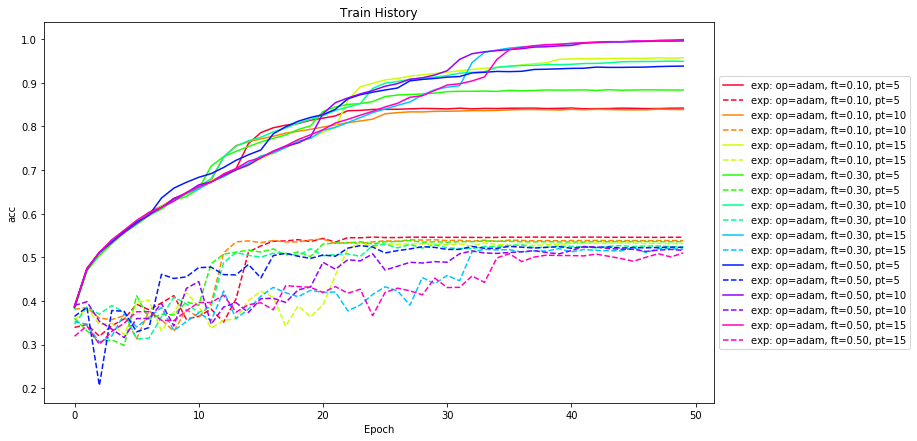

In [13]:
batch_trainer.display('acc', 'val_acc')

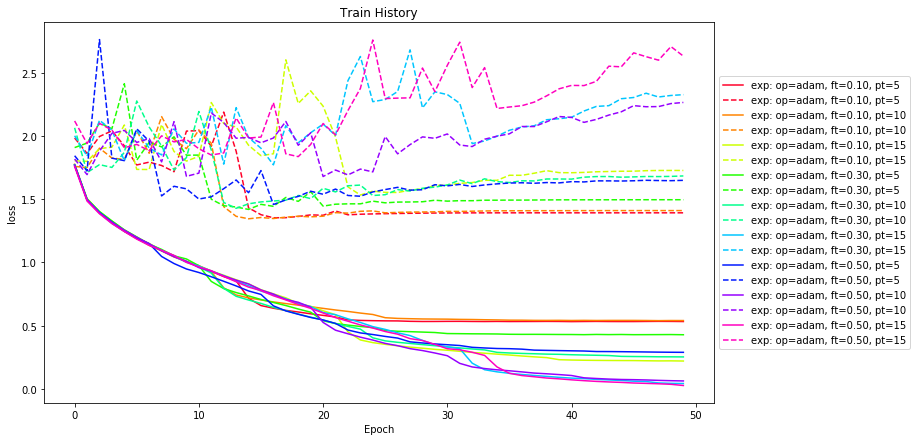

In [14]:
batch_trainer.display('loss', 'val_loss')

## 以 RMSprop 優化器和不同的降低學習率參數觀看學習曲線的走勢

In [15]:
# 設定超參數
optimizers = [(RMSprop, {},)]
rlrop_factors = [0.1, 0.3, 0.5]
rlrop_patiences = [5, 10, 15]

params = [BuildParam(*optimizer, rlrop_factor, rlrop_patience) for optimizer, rlrop_factor, rlrop_patience
          in itertools.product(optimizers, rlrop_factors, rlrop_patiences)]
trainers = [Trainer(X_train, y_train, X_test, y_test, param) for param in params]

In [16]:
batch_trainer = BatchTrainer(trainers).run()

Experiment with label: op=rmsprop, ft=0.10, pt=5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 3072)              0         
_________________________________________________________________
hidden_layer0 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batc

Epoch 7/50
 - 9s - loss: 1.2020 - acc: 0.5762 - val_loss: 1.8465 - val_acc: 0.3588
Epoch 8/50
 - 9s - loss: 1.1543 - acc: 0.5936 - val_loss: 2.3544 - val_acc: 0.2985
Epoch 9/50
 - 9s - loss: 1.1238 - acc: 0.6045 - val_loss: 2.1318 - val_acc: 0.3115
Epoch 10/50
 - 9s - loss: 1.0857 - acc: 0.6162 - val_loss: 1.8913 - val_acc: 0.3782
Epoch 11/50
 - 9s - loss: 1.0539 - acc: 0.6280 - val_loss: 1.8713 - val_acc: 0.3833
Epoch 12/50
 - 9s - loss: 1.0175 - acc: 0.6435 - val_loss: 2.0789 - val_acc: 0.3522
Epoch 13/50
 - 9s - loss: 0.9835 - acc: 0.6540 - val_loss: 2.2126 - val_acc: 0.3367
Epoch 14/50
 - 9s - loss: 0.9546 - acc: 0.6650 - val_loss: 1.7616 - val_acc: 0.4192
Epoch 15/50
 - 9s - loss: 0.9307 - acc: 0.6759 - val_loss: 1.8571 - val_acc: 0.4258
Epoch 16/50
 - 9s - loss: 0.8916 - acc: 0.6878 - val_loss: 1.7809 - val_acc: 0.4297
Epoch 17/50
 - 9s - loss: 0.8672 - acc: 0.6968 - val_loss: 1.7857 - val_acc: 0.4229
Epoch 18/50
 - 9s - loss: 0.8333 - acc: 0.7099 - val_loss: 1.7832 - val_acc: 0.

Epoch 33/50
 - 9s - loss: 0.3965 - acc: 0.8872 - val_loss: 1.5415 - val_acc: 0.5346
Epoch 34/50
 - 9s - loss: 0.3884 - acc: 0.8895 - val_loss: 1.5556 - val_acc: 0.5362
Epoch 35/50
 - 9s - loss: 0.3807 - acc: 0.8936 - val_loss: 1.5699 - val_acc: 0.5352
Epoch 36/50
 - 9s - loss: 0.3726 - acc: 0.8958 - val_loss: 1.5738 - val_acc: 0.5379
Epoch 37/50
 - 9s - loss: 0.3655 - acc: 0.8989 - val_loss: 1.5740 - val_acc: 0.5352
Epoch 38/50
 - 9s - loss: 0.3585 - acc: 0.9008 - val_loss: 1.6031 - val_acc: 0.5313
Epoch 39/50
 - 9s - loss: 0.3502 - acc: 0.9056 - val_loss: 1.6114 - val_acc: 0.5298
Epoch 40/50
 - 9s - loss: 0.3436 - acc: 0.9059 - val_loss: 1.6292 - val_acc: 0.5340
Epoch 41/50
 - 9s - loss: 0.3362 - acc: 0.9102 - val_loss: 1.6466 - val_acc: 0.5311

Epoch 00041: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 42/50
 - 9s - loss: 0.3193 - acc: 0.9171 - val_loss: 1.6225 - val_acc: 0.5345
Epoch 43/50
 - 9s - loss: 0.3162 - acc: 0.9192 - val_loss: 1.6250 - val_acc: 0

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
 - 10s - loss: 1.7903 - acc: 0.3787 - val_loss: 2.3411 - val_acc: 0.2646
Epoch 2/50
 - 9s - loss: 1.5315 - acc: 0.4589 - val_loss: 2.3287 - val_acc: 0.2698
Epoch 3/50
 - 9s - loss: 1.4315 - acc: 0.4937 - val_loss: 2.1480 - val_acc: 0.3185
Epoch 4/50
 - 9s - loss: 1.3527 - acc: 0.5243 - val_loss: 2.0870 - val_acc: 0.3322
Epoch 5/50
 - 9s - loss: 1.2969 - acc: 0.5411 - val_loss: 1.8446 - val_acc: 0.3712
Epoch 6/50
 - 9s - loss: 1.2461 - acc: 0.5610 - val_loss: 2.0126 - val_acc: 0.3371
Epoch 7/50
 - 9s - loss: 1.2017 - acc: 0.5747 - val_loss: 2.0563 - val_acc: 0.3394
Epoch 8/50
 - 9s - loss: 1.1535 - acc: 0.5952 - val_loss: 2.0039 - val_acc: 0.3530
Epoch 9/50
 - 9s - loss: 1.1201 - acc: 0.6051 - val_loss: 1.8446 - val_acc: 0.3714
Epoch 10/50
 - 9s - loss: 1.0856 - acc: 0.6162 - val_loss: 2.4678 - val_acc: 0.3380
Epoch 11/50
 - 9s - loss: 1.0544 - acc: 0.6305 - val_loss: 1.9086 - val_acc: 0.3852
Epoch 12/50
 - 9s - loss: 1.0144 -

Epoch 26/50
 - 9s - loss: 0.4880 - acc: 0.8469 - val_loss: 1.5594 - val_acc: 0.5247
Epoch 27/50
 - 9s - loss: 0.4685 - acc: 0.8545 - val_loss: 1.5605 - val_acc: 0.5201
Epoch 28/50
 - 9s - loss: 0.4507 - acc: 0.8605 - val_loss: 1.6338 - val_acc: 0.5150
Epoch 29/50
 - 9s - loss: 0.4308 - acc: 0.8689 - val_loss: 1.5796 - val_acc: 0.5270
Epoch 30/50
 - 9s - loss: 0.4167 - acc: 0.8731 - val_loss: 1.7051 - val_acc: 0.5033
Epoch 31/50
 - 9s - loss: 0.3985 - acc: 0.8802 - val_loss: 1.7025 - val_acc: 0.5088
Epoch 32/50
 - 9s - loss: 0.3822 - acc: 0.8869 - val_loss: 1.7072 - val_acc: 0.5137
Epoch 33/50
 - 9s - loss: 0.3677 - acc: 0.8909 - val_loss: 1.7437 - val_acc: 0.5090
Epoch 34/50
 - 9s - loss: 0.3519 - acc: 0.8982 - val_loss: 1.8130 - val_acc: 0.5111
Epoch 35/50
 - 9s - loss: 0.3396 - acc: 0.9022 - val_loss: 1.7929 - val_acc: 0.5112
Epoch 36/50
 - 9s - loss: 0.3247 - acc: 0.9084 - val_loss: 1.8183 - val_acc: 0.5098
Epoch 37/50
 - 9s - loss: 0.3117 - acc: 0.9114 - val_loss: 1.9874 - val_acc:

 - 9s - loss: 0.3469 - acc: 0.9092 - val_loss: 1.6539 - val_acc: 0.5310
Epoch 49/50
 - 9s - loss: 0.3458 - acc: 0.9096 - val_loss: 1.6542 - val_acc: 0.5297
Epoch 50/50
 - 9s - loss: 0.3459 - acc: 0.9093 - val_loss: 1.6563 - val_acc: 0.5293
Experiment with label: op=rmsprop, ft=0.50, pt=10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 3072)              0         
_________________________________________________________________
hidden_layer0 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)          

Epoch 8/50
 - 9s - loss: 1.1539 - acc: 0.5916 - val_loss: 2.0807 - val_acc: 0.3662
Epoch 9/50
 - 9s - loss: 1.1190 - acc: 0.6059 - val_loss: 1.9777 - val_acc: 0.3715
Epoch 10/50
 - 9s - loss: 1.0860 - acc: 0.6155 - val_loss: 1.7333 - val_acc: 0.4132
Epoch 11/50
 - 9s - loss: 1.0442 - acc: 0.6307 - val_loss: 2.2428 - val_acc: 0.3462
Epoch 12/50
 - 9s - loss: 1.0188 - acc: 0.6411 - val_loss: 2.1651 - val_acc: 0.3152
Epoch 13/50
 - 9s - loss: 0.9853 - acc: 0.6520 - val_loss: 2.1989 - val_acc: 0.3357
Epoch 14/50
 - 9s - loss: 0.9612 - acc: 0.6611 - val_loss: 1.8168 - val_acc: 0.4083
Epoch 15/50
 - 9s - loss: 0.9272 - acc: 0.6736 - val_loss: 2.0838 - val_acc: 0.3587
Epoch 16/50
 - 9s - loss: 0.8954 - acc: 0.6857 - val_loss: 1.9719 - val_acc: 0.3778
Epoch 17/50
 - 9s - loss: 0.8660 - acc: 0.6950 - val_loss: 2.0455 - val_acc: 0.3821
Epoch 18/50
 - 9s - loss: 0.8329 - acc: 0.7067 - val_loss: 1.9301 - val_acc: 0.4119
Epoch 19/50
 - 9s - loss: 0.8032 - acc: 0.7188 - val_loss: 1.9069 - val_acc: 0

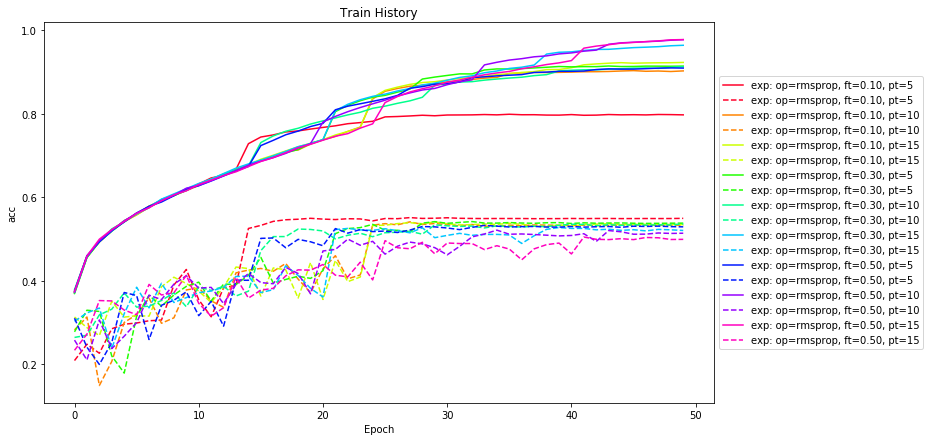

In [17]:
batch_trainer.display('acc', 'val_acc')

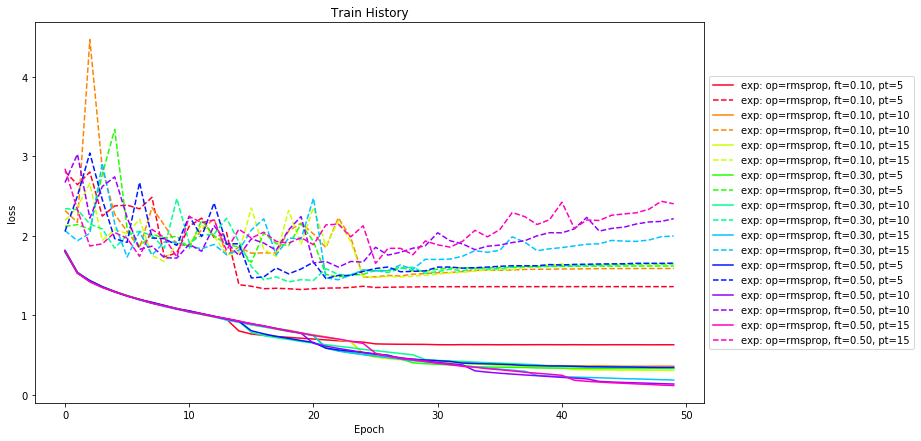

In [18]:
batch_trainer.display('loss', 'val_loss')